<a href="https://colab.research.google.com/github/Aayush077/ML/blob/main/earthquake_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earthquake Prediction


##Importing Libraries

In [26]:
import pandas as pd
import numpy as np
from google.colab import data_table
import matplotlib.pyplot as plt
!pip install cartopy
import cartopy.crs as ccrs
import seaborn as sns

##Importing dataset

In [27]:
data_table.enable_dataframe_formatter()

df_raw = pd.read_csv('earthquake_1995-2023.csv')

display(df_raw.head())
display(df_raw.shape)

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN


(1000, 19)

In [28]:
print(df_raw.columns)


Index(['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami',
       'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude',
       'longitude', 'location', 'continent', 'country'],
      dtype='object')


###Visualization of data

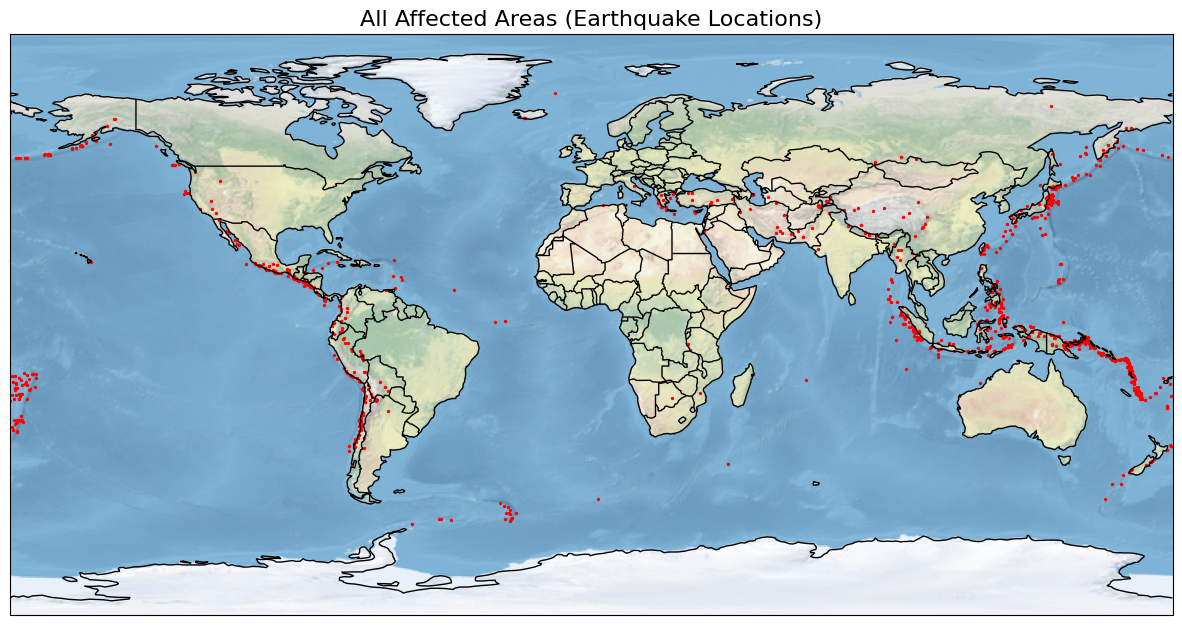

In [29]:
plt.figure(figsize=(15,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Draw land, ocean, borders, coastlines
ax.coastlines()
ax.stock_img()  # Light background
ax.add_feature(__import__("cartopy").feature.BORDERS)

# Plot earthquake points
plt.scatter(df_raw['longitude'], df_raw['latitude'],s=2, color='red',
    transform=ccrs.PlateCarree()
)

plt.title("All Affected Areas (Earthquake Locations)", fontsize=16)
plt.show()


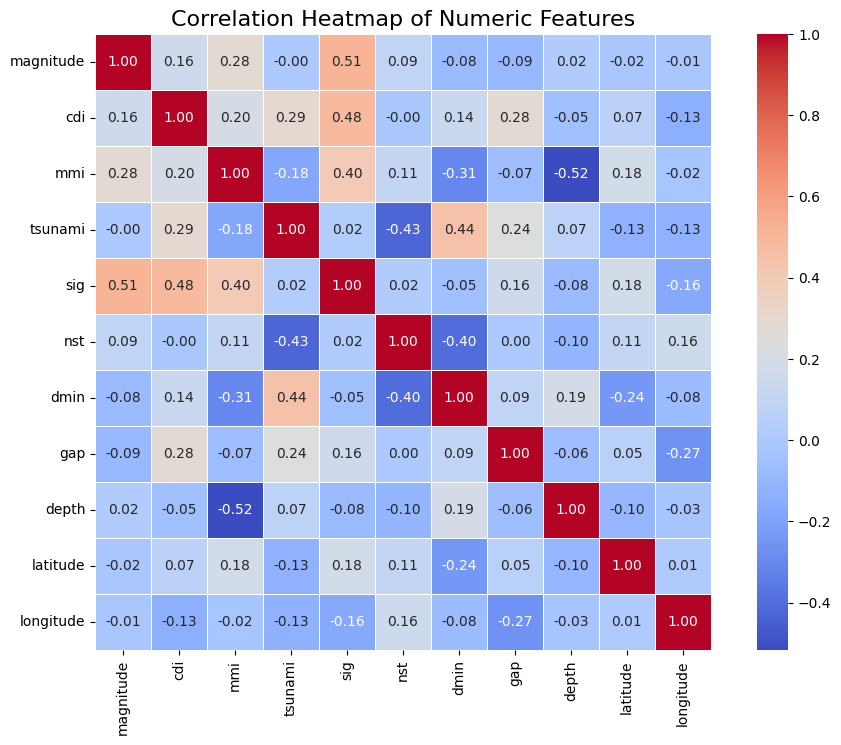

In [30]:
#Correlation HEATMAP
plt.figure(figsize=(12,8))

corr = df_raw.select_dtypes(include='number').corr()

sns.heatmap(
    corr, cmap='coolwarm', annot=True, fmt=".2f",
    square=True, cbar=True, linewidths=0.5, linecolor='white'
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()


##Preprocessing & Spliting


###Shows information about your dataset, Creates a safe copy to work on

In [31]:
# Inspect columns and summary info
print('Columns:', list(df_raw.columns))
print('\nDtypes:\n', df_raw.dtypes)
print('\nMissing values per column:\n', df_raw.isna().sum())

# Make a safe copy to work on
df = df_raw.copy()


Columns: ['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']

Dtypes:
 title         object
magnitude    float64
date_time     object
cdi            int64
mmi            int64
alert         object
tsunami        int64
sig            int64
net           object
nst            int64
dmin         float64
gap          float64
magType       object
depth        float64
latitude     float64
longitude    float64
location      object
continent     object
country       object
dtype: object

Missing values per column:
 title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       6
continent    716
country      349
dtype: int64


In [32]:
# clean and standardize column names – only rename what exists in your dataset
col_map = {
    'mag': 'magnitude',
    'magnitude': 'magnitude',
    'date_time': 'date_time',
    'time': 'time',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'depth': 'depth',
    'magType': 'magType',
    'nst': 'num_stations',
    'dmin': 'dmin',
    'gap': 'gap',
    'rms': 'rms',
    'mmi': 'mmi',
    'cdi': 'cdi',
    'alert': 'alert',
    'tsunami': 'tsunami',
    'country': 'country',
    'continent': 'continent',
    'location': 'location',
    'title': 'title',
    'sig': 'sig'
}

# Apply renaming only to matching columns
df = df.rename(columns={col: col_map[col] for col in df.columns if col in col_map})

print("Renamed columns:")
print(df.columns.tolist())


Renamed columns:
['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'num_stations', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']


In [33]:
# Parse datetime column
# If 'date_time' is already the index, reset it to bring it back as a column
if df.index.name == 'date_time':
    df = df.reset_index()

df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

print("Invalid datetime rows:", df['date_time'].isna().sum())

# Create simple time features
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

# Set datetime as index
df = df.set_index('date_time')


Invalid datetime rows: 0


/tmp/ipython-input-3577041554.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')


In [34]:
# Select useful features
feature_list = [
    'latitude','longitude','depth','num_stations','dmin','gap','rms',
    'mmi','cdi','tsunami','sig','year','month','hour',
    'magType','alert','continent','country','location','title'
]

# Keep only columns that exist
keep_cols = [c for c in feature_list if c in df.columns]
print("Keeping columns:", keep_cols)

# Build final modeling dataframe
df_model = df[keep_cols + ['magnitude']].copy()

# Drop rows with missing target
df_model = df_model.dropna(subset=['magnitude'])

# Fill missing values
num_cols = df_model.select_dtypes(include=['number']).columns.drop('magnitude')
df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

cat_cols = df_model.select_dtypes(include=['object']).columns
df_model[cat_cols] = df_model[cat_cols].fillna('missing')

print("Missing values after cleaning:\n", df_model.isna().sum())


Keeping columns: ['latitude', 'longitude', 'depth', 'num_stations', 'dmin', 'gap', 'mmi', 'cdi', 'tsunami', 'sig', 'year', 'month', 'hour', 'magType', 'alert', 'continent', 'country', 'location', 'title']
Missing values after cleaning:
 latitude        0
longitude       0
depth           0
num_stations    0
dmin            0
gap             0
mmi             0
cdi             0
tsunami         0
sig             0
year            0
month           0
hour            0
magType         0
alert           0
continent       0
country         0
location        0
title           0
magnitude       0
dtype: int64


### CORE PREPROCESSING AND SPLITING OF DATASET

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

# Train-test split
X = df_model.drop(columns=['magnitude'])
y = df_model['magnitude']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Train/Test shapes: (800, 19) (200, 19)
Numeric: ['latitude', 'longitude', 'depth', 'num_stations', 'dmin', 'gap', 'mmi', 'cdi', 'tsunami', 'sig', 'year', 'month', 'hour']
Categorical: ['magType', 'alert', 'continent', 'country', 'location', 'title']


## RANDOMFOREST REG

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Simple pipeline (no grid search)
rf_model = Pipeline([
    ("pre", preprocessor),("model", RandomForestRegressor(
        n_estimators=200, max_depth=20,random_state=42,n_jobs=-1))
])

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Scores
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RandomForest MSE: {mse_rf:.4f}")
print(f"RandomForest R²: {r2_rf:.4f}")


RandomForest MSE: 0.0410
RandomForest R²: 0.7902


### Visualization(Actual vs Predicted RandomForestReg)

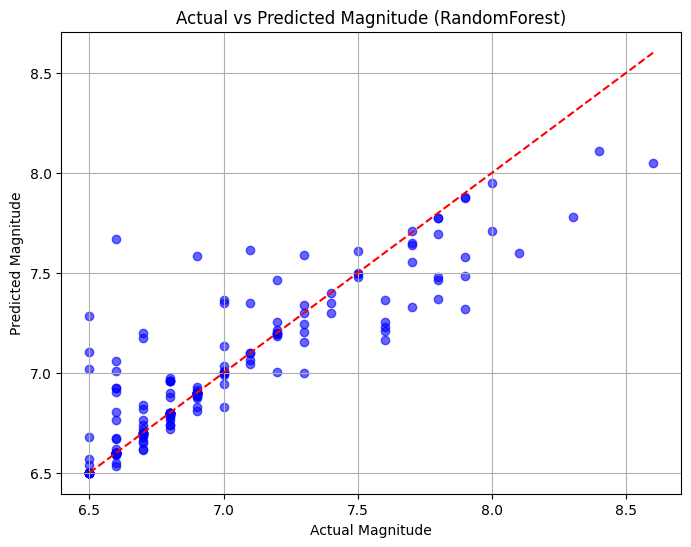

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')

plt.title("Actual vs Predicted Magnitude (RandomForest)")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.grid(True)
plt.show()


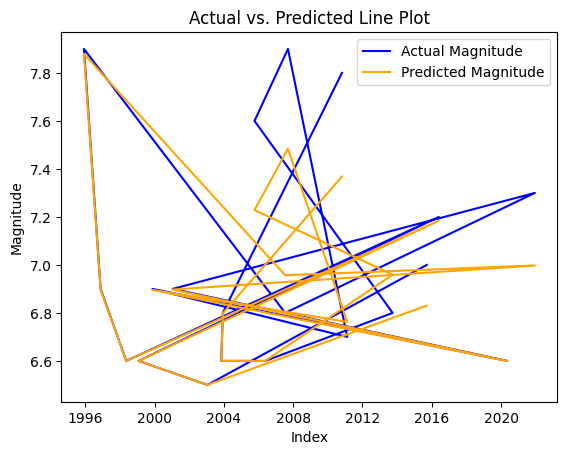

In [38]:
plt.plot(y_test.index[:20], y_test[:20], color='blue', label='Actual Magnitude')
plt.plot(y_test.index[:20], y_pred_rf[:20], color='orange', label='Predicted Magnitude')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Line Plot')
plt.legend()
plt.show()

###Top Feature Importances (RandomForest)

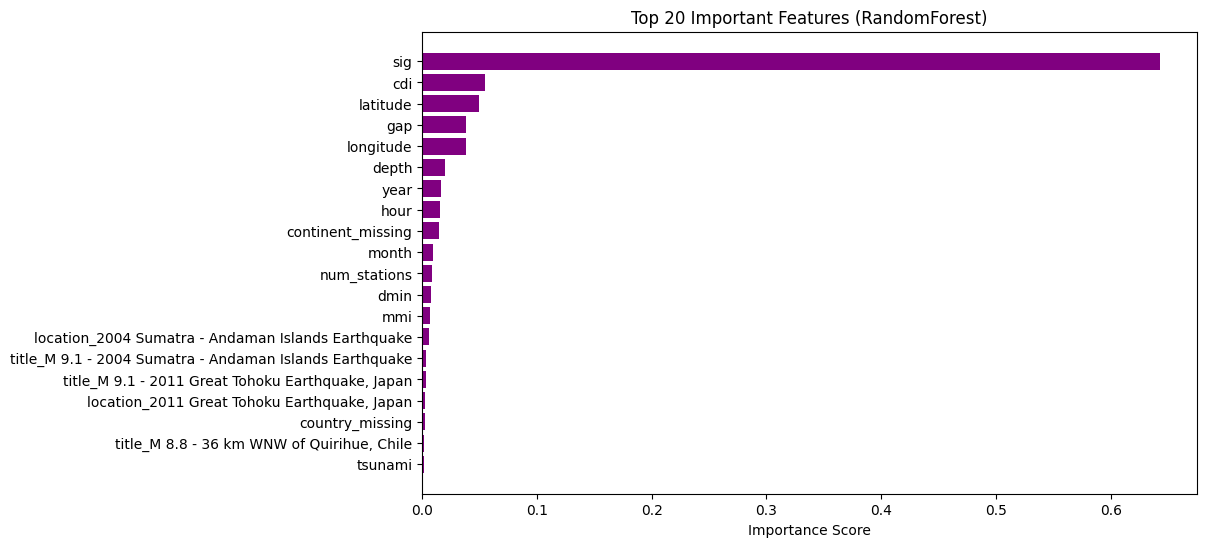

In [39]:
# Extract the trained RandomForest model
rf = rf_model.named_steps["model"]

# Get encoded categorical feature names
ohe = rf_model.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()

# Combine with numeric feature names
all_feature_names = numeric_features + cat_feature_names

# Create importance dataframe
importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf.feature_importances_
})

# Sort and plot top 20
top_features = importances.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_features["feature"], top_features["importance"], color="purple")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (RandomForest)")
plt.xlabel("Importance Score")
plt.show()


## XG BOOST REG

In [40]:
try:
    from xgboost import XGBRegressor

    xgb_model = Pipeline([
        ("pre", preprocessor),
        ("model", XGBRegressor( objective='reg:squarederror',n_estimators=200,
            max_depth=6,learning_rate=0.1, random_state=42, n_jobs=-1
        ))
    ])

    # Train
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred_xgb = xgb_model.predict(X_test)

    # Scores
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    print(f"XGBoost MSE: {mse_xgb:.4f}")
    print(f"XGBoost R²: {r2_xgb:.4f}")

except Exception as e:
    print("XGBoost not available:", e)


XGBoost MSE: 0.0426
XGBoost R²: 0.7822


### Visualization(Actual Vs Predicted XGBoostReg)

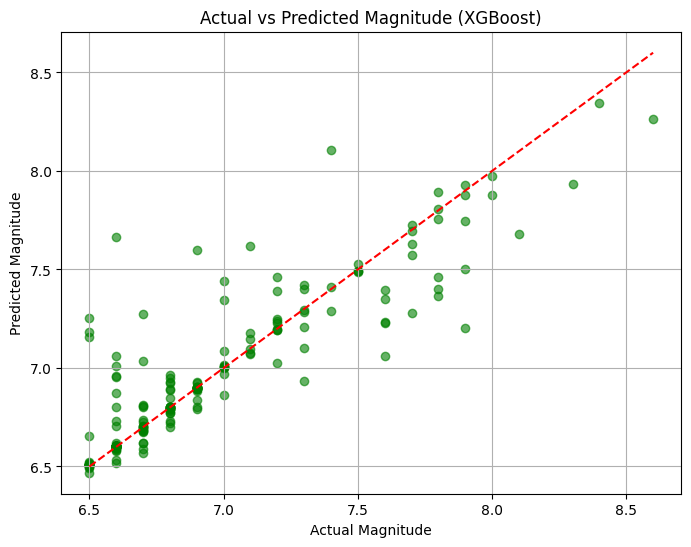

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')

plt.title("Actual vs Predicted Magnitude (XGBoost)")
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.grid(True)
plt.show()


###Top Feature Importances (SVR)

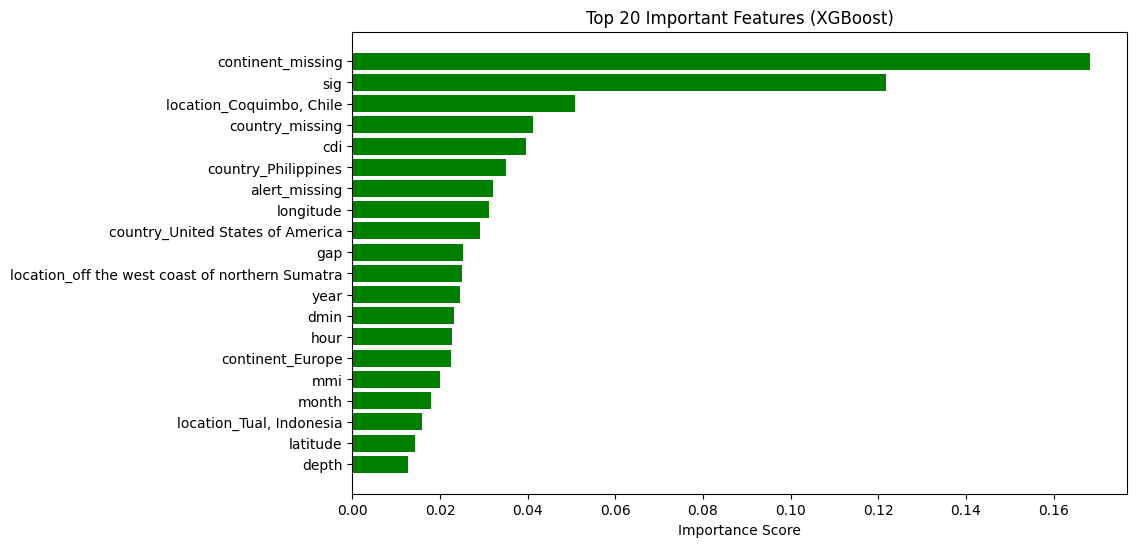

In [42]:
try:
    # Extract the trained XGBoost model
    xgb = xgb_model.named_steps["model"]

    # Get feature names (numeric + encoded categorical)
    ohe = xgb_model.named_steps["pre"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()

    all_feature_names = numeric_features + cat_feature_names

    # Get importance scores
    importances = pd.DataFrame({
        "feature": all_feature_names,
        "importance": xgb.feature_importances_
    })

    # Sort top 20
    top_features = importances.sort_values("importance", ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(top_features["feature"], top_features["importance"], color="green")
    plt.gca().invert_yaxis()
    plt.title("Top 20 Important Features (XGBoost)")
    plt.xlabel("Importance Score")
    plt.show()

except Exception as e:
    print("XGBoost feature importance not available:", e)


##RESULTS

In [43]:
# Evaluation Summary
results = []

results.append({ "model": "RandomForest","mse": mse_rf, "r2": r2_rf})

try:
    results.append({"model": "XGBoost", "mse": mse_xgb,"r2": r2_xgb})
except:
    pass

res_df = pd.DataFrame(results)
display(res_df)


,model,mse,r2
0,RandomForest,0.040998,0.790164
1,XGBoost,0.042556,0.782189


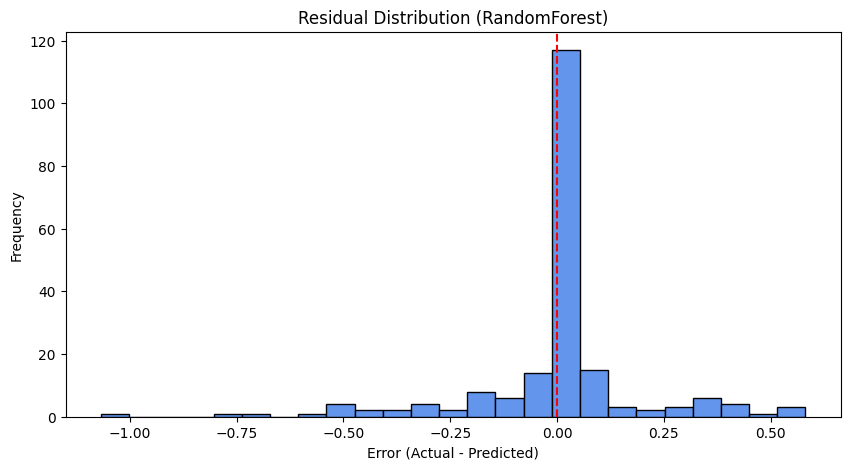

In [44]:
# Residuals (errors)
rf_residuals = y_test - y_pred_rf

plt.figure(figsize=(10,5))
plt.hist(rf_residuals, bins=25, color='cornflowerblue', edgecolor='black')
plt.title("Residual Distribution (RandomForest)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()


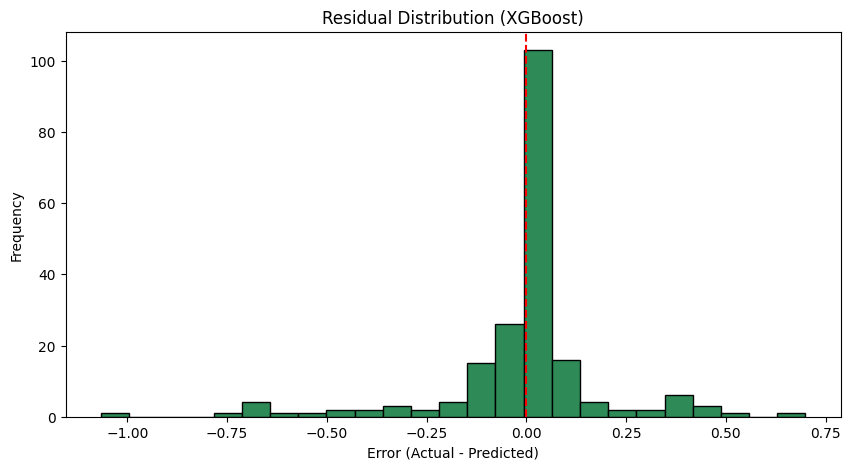

In [45]:
try:
    xgb_residuals = y_test - y_pred_xgb

    plt.figure(figsize=(10,5))
    plt.hist(xgb_residuals, bins=25, color='seagreen', edgecolor='black')
    plt.title("Residual Distribution (XGBoost)")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.axvline(0, color='red', linestyle='--')
    plt.show()
except:
    pass


In [46]:
df_model.to_csv("earthquake_cleaned.csv", index=True)
print("Cleaned dataset saved as earthquake_cleaned.csv")


Cleaned dataset saved as earthquake_cleaned.csv
